In [3]:
import os
import re
import pickle
import random
import json
from typing import Tuple, List

import numpy as np
import pandas as pd

from collections import Counter
from collections import defaultdict

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from ufal.morphodita import Morpho, Tagger, TaggedLemmas,\
    Forms, TaggedLemmasForms, TokenRanges

from nltk.tokenize import sent_tokenize, word_tokenize

In [2]:
def plot_frequency(frequency, x_label=None, y_label=None, filename=None):
    width = 1

    labels, values = zip(*frequency.items())

    df = pd.DataFrame({
        'Labels': labels,
        'Frequencies': values
    })
    df = df.sort_values('Frequencies', ascending=False)

    indexes = np.arange(len(df['Labels']))
    width = 1

    plt.bar(indexes, df['Frequencies'], width)
    plt.xticks(indexes + width * 0.5, df['Labels'], rotation=45 if len(str(labels[0])) > 3 else 0, ha='right')
    
    if x_label is not None:
        plt.xlabel(x_label)

    if y_label is not None:
        plt.ylabel(y_label)
    
    plt.tight_layout()
    
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [ ]:
morpho = Morpho.load('othermodels/czech-morfflex2.0-220710.dict')
tagger = Tagger.load('othermodels/czech-morfflex2.0-pdtc1.0-220710.tagger')

def tag_text(text: str):
    """
    Tag tokens of the text.
    :param text: text to tag
    :return: tagged text
    """
    forms = Forms()
    lemmas = TaggedLemmas()
    tokens = TokenRanges()
    tokenizer = tagger.newTokenizer()

    tokenizer.setText(text)
    result = []
    while tokenizer.nextSentence(forms, tokens):
        tagger.tag(forms, lemmas)

        for token_struct, lemma_struct in zip(tokens, lemmas):
            lemma = lemma_struct.lemma
            tag = lemma_struct.tag

            result.append({
                'lemma': morpho.rawLemma(lemma),
                'tag': tag,
                'token': text[token_struct.start: token_struct.start + token_struct.length]
            })

    return result


articles = []
for filename in os.listdir('dataset_parts/')[:12]:
    with open(f'dataset_parts/{filename}', mode='r') as f:
        articles.append(f.read())

articles = '\n'.join(articles)

sentences = articles.split('\n')

len(sentences)

# Calculate case and part of speech distribution

In [ ]:
case_occurrences = defaultdict(lambda: 0)
part_of_speech = defaultdict(lambda: 0)
part_of_speech_lengths = defaultdict(lambda: 0)

counter = 0
for sentence in sentences[:10_000]:
    tagged_sentence = tag_text(sentence)
    for token in tagged_sentence:
        pos = token['tag'][1 - 1]
        part_of_speech[pos] += 1
        part_of_speech_lengths[pos] += len(token['token'])
        
        if pos not in ['N', 'A', 'C', 'P']:
            continue

        case = token['tag'][5 - 1]
        case_occurrences[case] += 1

    counter += 1
    
    if counter % 1000 == 0:
        print(counter)

for pos in part_of_speech.keys():
    part_of_speech_lengths[pos] /= part_of_speech[pos]


In [ ]:
plot_frequency(case_occurrences, filename='case-distribution-cs.svg')

In [ ]:
plot_frequency(part_of_speech_lengths, filename='pos-lengths-cs.svg')

In [ ]:
plot_frequency(part_of_speech, filename='pos-distribution-cs.svg')

In [ ]:
weighted_pos_length = {}

total_pos_count = sum(part_of_speech.values())

for pos in part_of_speech.keys():
    part_of_speech_count = part_of_speech[pos]
    part_of_speech_length = part_of_speech_lengths[pos]
    
    weighted_pos_length[pos] = (part_of_speech_count / total_pos_count) * part_of_speech_length


plot_frequency(weighted_pos_length, filename='pos-weighted-length-cs.svg')

# Preposition exploration
Find distribution of cases of words after prepositions.

In [ ]:
PREPOSITION_TAG = 'R'

prepositions = defaultdict(lambda: defaultdict(lambda: 0))

counter = 0
for sentence in sentences[:10_000]:
    sentence = sentence.lower()
    tagged_sentence = tag_text(sentence)
    for idx in range(len(tagged_sentence) - 1):
        previous_token = tagged_sentence[idx]
        cur_token = tagged_sentence[idx + 1]
        
        if previous_token['tag'][1 - 1] != PREPOSITION_TAG\
           or cur_token['tag'][1 - 1] not in ['N', 'A', 'C', 'P']:
            continue
        
        connected_case = cur_token['tag'][5 - 1]
        
        if connected_case in ['-', 'X']:
            continue
        
        prepositions[previous_token['token']][connected_case] += 1

    counter += 1
    
    if counter % 1000 == 0:
        print(counter)

## Find preposition -> case mapping
Find mapping between prepositions and most likely case of word following it.

In [ ]:
prepositions_only_highest = {}
for prep in prepositions.keys():
    occurrences = prepositions[prep]
    case_with_max_occ = max(occurrences, key=occurrences.get)
    if occurrences[case_with_max_occ] < 100:
        continue
    prepositions_only_highest[prep] = case_with_max_occ

prepositions_only_highest

## Save the mapping

In [ ]:
with open('prepositions.pickle', mode='wb') as f:
    pickle.dump(prepositions_only_highest, f)

# Show wordcloud with characters

In [ ]:
language = 'cs'

alphabet_regexp = r'[а-щьюяґєії]' if language == 'uk' else r'[a-z]'

frequencies = Counter()

counter = 0
filenames = os.listdir('dataset_parts/')[:5]
total = len(filenames)

for filename in filenames:
    with open(f'dataset_parts/{filename}', mode='r') as f:
        text = list(f.read().lower())
        text = list(filter(lambda c: re.match(alphabet_regexp, c), text))
        frequencies = frequencies + Counter(text)
        counter += 1
        print(f'Done {counter} out of {total}.')

labels, values = zip(*frequencies.items())

df = pd.DataFrame({
    'Labels': labels,
    'Frequencies': values
})
df = df.sort_values('Frequencies', ascending=False)

wordcloud = WordCloud().fit_words(frequencies)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Word statistics
Calculation of statistics on words, such as
- average word length in per language,
- distribution of cases, or
- distribution of cases vs. length.

In [63]:
def iterate_words(language: str, part_count: int, dataset_parts='../dataset_parts/'):
    word_regexp = r'[а-щьюяґєії]+' if language == 'uk' else r'[a-z]+'
    
    filenames = os.listdir(dataset_parts)[:part_count]
    for filename in filenames:
        with open(f'{dataset_parts}/{filename}', mode='r') as f:
            text = f.read().lower()
            tokens = list(filter(lambda w: re.match(word_regexp, w), word_tokenize(text, language='czech')))
            yield from tokens

In [65]:
length_freq = defaultdict(lambda: 0)

language = 'cs'

for w in iterate_words(language, 40, '../dataset_parts_cs/'):
    if len(w) > 20:
        continue
    length_freq[len(w)] += 1

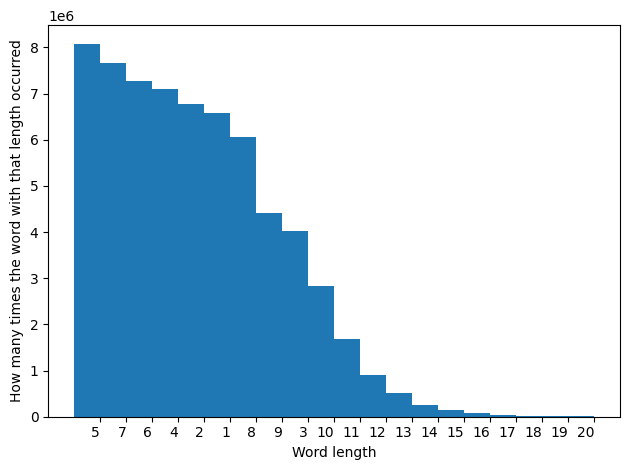

In [66]:
plot_frequency(length_freq, x_label="Word length", y_label="How many times the word with that length occurred", filename='uk-word-length-distribution.svg' if language == 'uk' else 'cs-word-length-distribution.svg')

In [68]:
with open('word-len-dist-cs.pickle', mode='wb') as f:
    pickle.dump(dict(length_freq), f)

In [69]:
char_count = sum(k * v for k, v in length_freq.items())
word_count = sum(length_freq.values())
avg = char_count / word_count
print(f'Average word lenth in {language} is: {avg}')

Average word lenth in cs is: 5.577700469778011


In [ ]:
language = 'cs'

alphabet_regexp = r'[а-щьюяґєії]' if language == 'uk' else r'[a-z]'

frequencies = Counter()

counter = 0
filenames = os.listdir('dataset_parts/')[:5]
total = len(filenames)

for filename in filenames:
    with open(f'dataset_parts/{filename}', mode='r') as f:
        text = list(f.read().lower())
        text = list(filter(lambda c: re.match(alphabet_regexp, c), text))
        frequencies = frequencies + Counter(text)
        counter += 1
        print(f'Done {counter} out of {total}.')

labels, values = zip(*frequencies.items())

df = pd.DataFrame({
    'Labels': labels,
    'Frequencies': values
})
df = df.sort_values('Frequencies', ascending=False)

wordcloud = WordCloud().fit_words(frequencies)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")